# New partition strategy: EdgePartitionTriangle

New partition strategy with several advantage:
1. nicer bound on vertex replication, sqrt(2 * numParts).
2. colocate all edges between two vertices regardless of direction. 
3. same work balance compared with EdgePartition2D  

### EdgePartition2D

    case object EdgePartition2D extends PartitionStrategy {
        override def getPartition(src: VertexId, dst: VertexId, numParts: PartitionID): PartitionID = {
          val ceilSqrtNumParts: PartitionID = math.ceil(math.sqrt(numParts)).toInt
          val mixingPrime: VertexId = 1125899906842597L
          if (numParts == ceilSqrtNumParts * ceilSqrtNumParts) {
            // Use old method for perfect squared to ensure we get same results
            val col: PartitionID = (math.abs(src * mixingPrime) % ceilSqrtNumParts).toInt
            val row: PartitionID = (math.abs(dst * mixingPrime) % ceilSqrtNumParts).toInt
            (col * ceilSqrtNumParts + row) % numParts

          } else {
            // Otherwise use new method
            val cols = ceilSqrtNumParts
            val rows = (numParts + cols - 1) / cols
            val lastColRows = numParts - rows * (cols - 1)
            val col = (math.abs(src * mixingPrime) % numParts / rows).toInt
            val row = (math.abs(dst * mixingPrime) % (if (col < cols - 1) rows else lastColRows)).toInt
            col * rows + row

          }
        }
      }

### EdgePartitionTriangle

    case object EdgePartitionTriangle extends PartitionStrategy {
        override def getPartition(src: VertexId, dst: VertexId, numParts: PartitionID): PartitionID = {
          val mixingPrime: VertexId = 1125899906842597L
          val numRowTriParts = ((math.sqrt(1 + 8 * numParts) - 1) / 2).toInt
          val numTriParts = numRowTriParts * (numRowTriParts + 1) / 2
          val segmentFactor = 100
          val numSegments = (segmentFactor * math.sqrt(4 * numParts * numTriParts)).toInt
          val segRow = (math.abs(src * mixingPrime) % numSegments).toInt
          val segCol = (math.abs(dst * mixingPrime) % numSegments).toInt
          var row = segRow / (segmentFactor * numRowTriParts)
          var col = segCol / (segmentFactor * numRowTriParts)
          if (math.max(segRow, segCol) >= 2 * segmentFactor * numTriParts) {
            // non triangle parts
            row = numRowTriParts + 1
            col = math.min(segRow, segCol) % (numParts - numTriParts)
          }
          else if (row == col) {
            // diagonal parts
            val ind = math.min(segRow % numRowTriParts, segCol % numRowTriParts)
            col = (math.min(2 * numRowTriParts - ind - 1, ind) + row + 1) % (numRowTriParts + 1)
          }
          if (row > col) row * (row - 1) / 2 + col else col * (col - 1) / 2 + row
        }
      }


In [1]:
from __future__ import division
from IPython.html.widgets import interact, IntSlider
import math
import collections
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import numpy as np
np.seterr(all='ignore') #Ignore overflow warnings
%matplotlib inline

C:\Users\wenbinwei\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


We use `numpy.int64` to match Java's overflow behavior.

In [2]:
def edgePartition2D(src, dst, numParts):
    src = np.int64(src)
    dst = np.int64(dst)
    ceilSqrtNumParts = np.int64(math.ceil(math.sqrt(numParts)))
    mixingPrime = np.int64(1125899906842597)
    cols = ceilSqrtNumParts
    rows = (numParts + cols - 1) // cols
    lastColRows = numParts - rows * (cols - 1)
    col = int(abs(src * mixingPrime) % numParts // rows)
    row = int(abs(dst * mixingPrime) % (rows if (col < cols - 1) else lastColRows))
    return col * rows + row

In [3]:
def edgePartitionTriangle(src, dst, numParts):
    src = np.int64(src)
    dst = np.int64(dst)
    mixingPrime = np.int64(1125899906842597)
    numRowTriParts = int((math.sqrt(1 + 8 * numParts) - 1) / 2)
    numTriParts = numRowTriParts * (numRowTriParts + 1) // 2
    segmentFactor = 10
    numSegments = int(segmentFactor * math.sqrt(4 * numParts * numTriParts))
    segRow = int(abs(src * mixingPrime) % numSegments)
    segCol = int(abs(dst * mixingPrime) % numSegments)
    row = int(segRow / (segmentFactor * numRowTriParts))
    col = int(segCol / (segmentFactor * numRowTriParts))
    if max(segRow, segCol) >= 2 * segmentFactor * numTriParts:
        row = numRowTriParts + 1
        col = min(segRow, segCol) % (numParts - numTriParts)
    elif row == col:
        ind = min(segRow % numRowTriParts, segCol % numRowTriParts)
        col = (min(2 * numRowTriParts - ind - 1, ind) + row + 1) % (numRowTriParts + 1)
    return row * (row - 1) // 2 + col if row > col else col * (col - 1) // 2 + row

In [4]:
def rand_vid(l=-2**63, u=2**63 - 1):
    return random.randint(l, u)

In [5]:
def get_edges_counts(numParts, sample_size = 10000):
    cnt_2d = collections.Counter()
    cnt_tri = collections.Counter()
    for x in range(1, sample_size):
        src = rand_vid()
        dst = rand_vid()
        cnt_2d[edgePartition2D(src, dst, numParts)] += 1
        cnt_tri[edgePartitionTriangle(src, dst, numParts)] += 1
    return (cnt_2d, cnt_tri)

In [6]:
def viz_balance(numParts): 
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    cnt_2d, cnt_tri = get_edges_counts(numParts)

    def add_sub(sub_ind, data, title, sharey=None):
        ax = fig.add_subplot(sub_ind, sharey=sharey)
        ax.bar(*zip(*data.items()), align="edge", width=1)
        ax.set_xlim(0,numParts)
        ax.set_title('Balance - ' + title)
        ax.set_xlabel('partition number')
        ax.set_ylabel('number of edges')
        return ax
    ax = add_sub(121, cnt_tri, 'EdgePartitionTriangle')
    add_sub(122, cnt_2d, 'EdgePartition2D', ax)
    plt.show()

In [7]:
def viz_vertex_rep(numParts, edges):
    v2p_2d = dict()
    v2p_tri = dict()
    for src, dst in edges:
        pid_2d = edgePartition2D(src, dst, numParts)
        pid_tri = edgePartitionTriangle(src, dst, numParts)
        v2p_2d.setdefault(src, set()).add(pid_2d)
        v2p_2d.setdefault(dst, set()).add(pid_2d)
        v2p_tri.setdefault(src, set()).add(pid_tri)
        v2p_tri.setdefault(dst, set()).add(pid_tri)
        
    reps_count_2d = collections.Counter()
    reps_count_tri = collections.Counter()
    
    for v in v2p_2d.values():
        reps_count_2d[len(v)] += 1
    for v in v2p_tri.values():
        reps_count_tri[len(v)] += 1
    
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    def add_sub(sub_ind, data, title, sharey=None):
        ax = fig.add_subplot(sub_ind, sharey=sharey)
        ax.bar(*zip(*data.items()), align="edge", width=1)
        ax.set_xlim(0,max(data.keys()) + 1)
        ax.set_title('replications - ' + title)
        ax.set_xlabel('num of reps')
        ax.set_ylabel('count')
        return ax
    ax = add_sub(121, reps_count_tri, "EdgePartitionTriangle")
    add_sub(122, reps_count_2d, "EdgePartition2D", ax)
    plt.show()
    

In [8]:
def viz_reps_ave(edges, max_num_parts):
    def get_sum(numParts):
        v2p = dict()
        for src, dst in edges:
            pid_2d = edgePartition2D(src, dst, numParts)
            pid_tri = edgePartitionTriangle(src, dst, numParts)
            v2p.setdefault(src, [set(), set()])[0].add(pid_2d)
            v2p.setdefault(dst, [set(), set()])[0].add(pid_2d)
            v2p[src][1].add(pid_tri)
            v2p[dst][1].add(pid_tri)
        N = len(v2p)
        sum_2d = sum(len(v[0]) for v in v2p.values())
        sum_tri = sum(len(v[1]) for v in v2p.values())
        return sum_2d / N, sum_tri / N
    x = list(range(1, max_num_parts + 1))
    ys = [get_sum(i) for i in x]
    y_2d = [v[0] for v in ys]
    y_tri = [v[1] for v in ys]
    plt.plot(x, y_2d, 'r', x, y_tri, 'b')
    plt.xlabel("numParts")
    plt.ylabel("average reps")
    plt.legend(["2d", "tri"])
    plt.show()

EdgePartitionTriangle and EdgePartition2D has same work balance. 

In [9]:
interact(viz_balance, numParts=IntSlider(min=1, max=50, value=10))

A Jupyter Widget

<function __main__.viz_balance>

graph generated by `rand_vid(-2 ** 63, 2 ** 63 -1)` is too sparse to show the decresing in vertex replications. We have narrowed the range of random integers.

In [10]:
edges = [(rand_vid(-1000, 1000), rand_vid(-1000, 1000)) for _ in range(10000)]

In [11]:
def interact_viz_vertex_rep(numParts):
    return viz_vertex_rep(numParts, edges)
interact(interact_viz_vertex_rep, numParts=IntSlider(min=1, max=50, value=10))

A Jupyter Widget

<function __main__.interact_viz_vertex_rep>

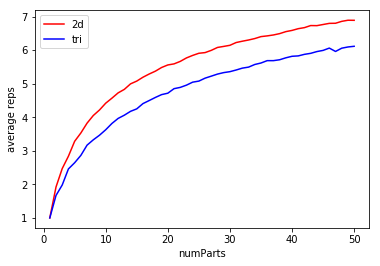

In [12]:
viz_reps_ave(edges, 50)